In [1]:
#libraries for visualization and organization
import pandas as pd

#libraries for modeling
import scipy
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report, accuracy_score, mean_squared_error, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import GradientBoostingClassifier

#silencing warnings and other rubbish
import warnings
warnings.filterwarnings("ignore")
#warnings.filterwarnings('always')

#for visualization
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict

#random forest, svm, nearest neighbors

C:\Users\Malconius\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


# The purpose of this notebook is to predict poverty level of Costa Rican households from a dataset determined by household characteristics. 

When a govenernment is able to determine the poverty level of its citizens without conducting household to household surveys, it is able to service public needs more successfully. Some policies are general and are intended to affect the entire country, but others may be more targetted towards a certain level of poverty, such as housing vouchers and subsidies. This exercise aims at deterimining the financial vulnerability of these households.

In [2]:
#loading in our training dataset -- no need for testing set as I will test my model exclusively on train-test splits
train = pd.read_csv(r"C:\Users\Malconius\Documents\Econ213R\hw4\train.csv")

Getting some basic descriptive data of our data before we start cleaning...

In [3]:
train.shape

(9557, 143)

It appears that we have 9557 observations, which includes several observations per household.

In [4]:
train.describe()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
count,2.697000e+03,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,2215.000000,9557.000000,9557.000000,...,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9552.000000,9557.000000,9557.000000
mean,1.652316e+05,0.038087,4.955530,0.023648,0.994768,0.957623,0.231767,1.404063,0.385895,1.559171,...,74.222769,1643.774302,19.132887,53.500262,3.844826,3.249485,3.900409,102.588867,1643.774302,3.302292
std,1.504571e+05,0.191417,1.468381,0.151957,0.072145,0.201459,0.421983,0.763131,0.680779,1.036574,...,76.777549,1741.197050,18.751395,78.445804,6.946296,4.129547,12.511831,93.516890,1741.197050,1.009565
min,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,1.000000
25%,8.000000e+04,0.000000,4.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,16.000000,289.000000,9.000000,0.000000,0.000000,1.000000,0.111111,36.000000,289.000000,3.000000
50%,1.300000e+05,0.000000,5.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,36.000000,961.000000,16.000000,36.000000,1.000000,2.250000,0.444444,81.000000,961.000000,4.000000
75%,2.000000e+05,0.000000,6.000000,0.000000,1.000000,1.000000,0.000000,2.000000,1.000000,2.000000,...,121.000000,2601.000000,25.000000,81.000000,4.000000,4.000000,1.777778,134.560010,2601.000000,4.000000
max,2.353477e+06,1.000000,11.000000,1.000000,1.000000,1.000000,1.000000,6.000000,5.000000,8.000000,...,441.000000,9409.000000,169.000000,441.000000,81.000000,36.000000,64.000000,1369.000000,9409.000000,4.000000


For my estimate I will only focus on head of houseshold information. Many surveys only record property and assets under the head of household, so most of the information I need will likely be found here. Additionally, each head of household is connected to a household size variable, which will relay other relevant information without retaining the other members. 

## Cleaning
Let's look at variables that have missing entries. Missing data may influence our estimates, depending on the model. 

In [5]:
#finding variables with missing values
train.isnull().sum().sort_values(ascending=False).head(6)

rez_esc      7928
v18q1        7342
v2a1         6860
meaneduc        5
SQBmeaned       5
techozinc       0
dtype: int64

In [6]:
#what are the possible values of years-behind in schooling
train.rez_esc.unique()

array([ nan,   1.,   0.,   3.,   2.,   4.,   5.])

In [7]:
#count if head of household and missing
train.parentesco1.unique()

array([1, 0], dtype=int64)

Now that we know how to determine which observations are coded as heads of household, let's find how many are between the age of 7-17. This age-range consists of the only ages that can have values for rez_esc, so if a head of household has a value, they must be in that range. 

In [8]:
#finding the number of household heads that are in the age-range 7-17
train.loc[(train.parentesco1==1) & (train.rez_esc.isnull()==False)].shape[0]

1

Because we only have one head of household that is between 7-17 years old, losing this information will not harm our estimates too much. Filling the rez_esc universally with this value will be mostly acceptable, at least on a first pass.

More importantly, we now know that this variable is systematically missing for our heads of household. Because of this, I don't feel any pressure to impute actual values for observations that are missing this data, so we can replace them with 0.

In [9]:
train.rez_esc = 0
train.rez_esc.unique()

array([0], dtype=int64)

Now that we have determined how many heads of household are in that age range, we can eliminate the other information. When we drop the other observations in our dataset, we are left with 2973 heads of household.

In [10]:
#only keeping rows that contain the head of household
# -- HOH will be the member of the household I categorize on in the end, so I will only keep it
train = train.loc[train.parentesco1==1]
train.shape

(2973, 143)

In [11]:
#looking at values still missing
train.isnull().sum().sort_values(ascending=False).head(6)

v18q1          2318
v2a1           2156
meaneduc          3
SQBmeaned         3
abastaguano       0
sanitario2        0
dtype: int64

We still have 4 variables with data missing, so let's take care of those now.

In [12]:
#finding possible values of tablet ownership
train.v18q.unique()

array([0, 1], dtype=int64)

Variable v18q1 is the number of tablets a household owns. I hypothesize that the missing values present in our data simply indicate that a household does not own a tablet at all. To check this, let's see how many observations we have where the household does not own a tablet (v18q) and also has a missing value:

In [13]:
#households that didn't have a tablet will have the missing value replaced with 0
#for future reference, .fillna(0) would have worked as well
print(train.loc[(train.v18q==0) & (train.v18q1.isnull()==True)].shape[0])

2318


I was indeed correct, that the two match up perfectly, so we can simply replace these values with 0.

In [14]:
train.loc[(train.v18q==0) & (train.v18q1.isnull()==True), 'v18q1'] = 0

In [15]:
#checking to see if all values were successfully replaced
train.loc[(train.v18q==0) & (train.v18q1.isnull()==True)].shape[0]

0

Our next variable of interest is v2a1: housing rent payments. Fortunately, we have another variable that describes the ownership type of the head of household. Let's graph the two together to see into which categories these owners fall. Do they own their house, rent it, pay a mortgage, or other?

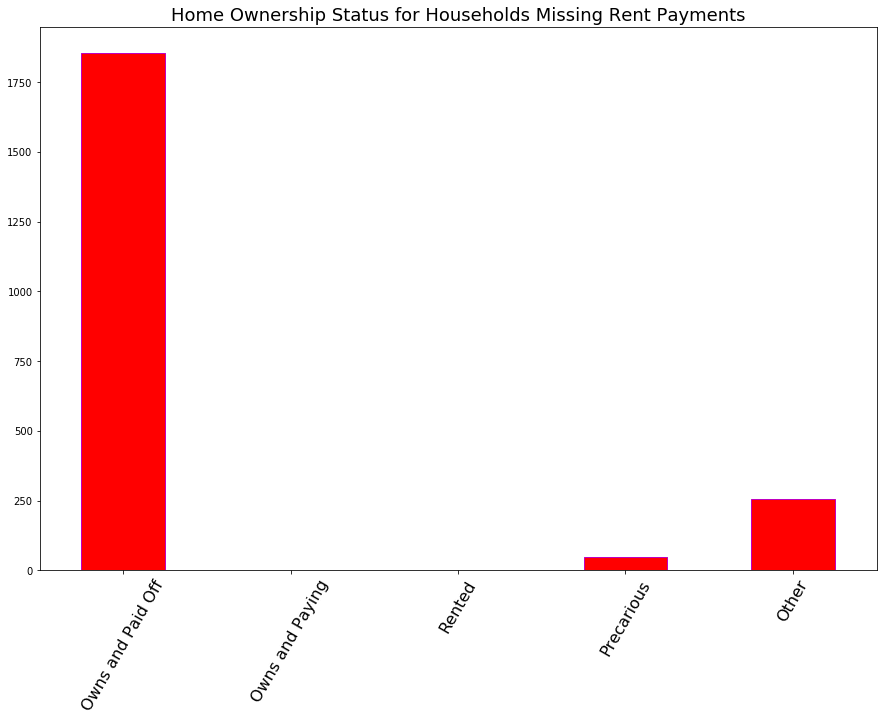

In [16]:
#checking monthly rent payment missing values -- it is likely that these are missing because the head of houeshold owns the house and pays no rent (and no imputed rent is present)
#creating an aggregated variable for houseownership 
houseownership_vars = [var for var in train if var.startswith('tipovivi')]
train.loc[train.v2a1.isnull(), houseownership_vars].sum().plot.bar(figsize = (15,10), color = 'red', edgecolor = 'm', linewidth = 1);
plt.xticks([0, 1, 2, 3, 4], ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'], rotation = 60, size = 16);
plt.title('Home Ownership Status for Households Missing Rent Payments', size = 18);

It looks like most of these missing values are collected under home-owners who no longer have to make payments on their house. These we can clearly replace with 0. Another appropriate response would be to impute rent for these individuals, but this would help us with another metric entirely. So, we won't worry about it. 

For the sake of time, we will replace the other missing values with 0 -- I do not know what they indicate, but for the sake of time I will replace them with the mean values.

In [17]:
#most heads of household already own their house, so we can just replace the missing payments with 0. The others we will impute
#train.loc[(train.tipovivi1 == 1), 'v2a1'] = 0
train.loc[(train.tipovivi1==1) & (train.v2a1.isnull()==True), 'v2a1'] = 0
train.loc[(train.tipovivi4==1) & (train.v2a1.isnull()==True), 'v2a1'] = train.loc[(train.tipovivi4==1) & (train.v2a1.isnull()==True)].fillna(train.v2a1.median())
train.loc[(train.tipovivi5==1) & (train.v2a1.isnull()==True), 'v2a1'] = train.loc[(train.tipovivi5==1) & (train.v2a1.isnull()==True)].fillna(train.v2a1.median())

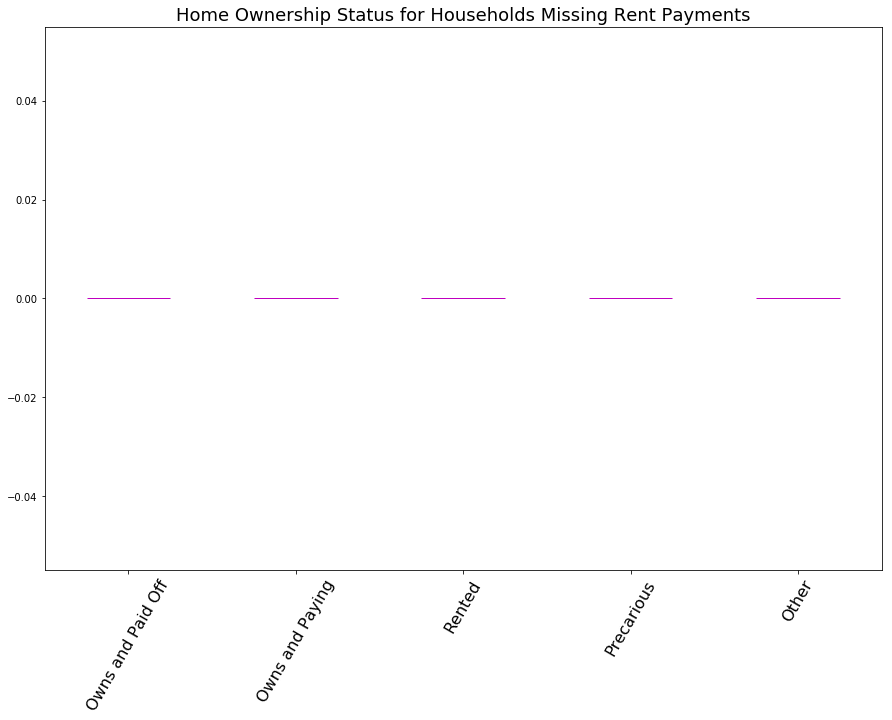

In [18]:
#checking monthly rent payment missing values -- it is likely that these are missing because the head of houeshold owns the house and pays no rent (and no imputed rent is present)
#creating an aggregated variable for houseownership 
houseownership_vars = [var for var in train if var.startswith('tipovivi')]
train.loc[train.v2a1.isnull(), houseownership_vars].sum().plot.bar(figsize = (15,10), color = 'red', edgecolor = 'm', linewidth = 1);
plt.xticks([0, 1, 2, 3, 4], ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'], rotation = 60, size = 16);
plt.title('Home Ownership Status for Households Missing Rent Payments', size = 18);

Looks like we succesfully accounted for all of the missing rent payment values. Let's take on the remaining two variables.

Looks like we have three missing values, so let's see if they connected-- three missing values in education values indicates to me that they are likely the same individual.

In [19]:
#looking at values still missing --- all seem to be fixed
train.isnull().sum().sort_values(ascending=False).head(3)

SQBmeaned    3
meaneduc     3
Target       0
dtype: int64

In [20]:
train.loc[(train.SQBmeaned.isnull()==True) & (train.meaneduc.isnull()==True)].shape[0]

3

Looks like I was correct: the three values that are missing in both categories are missing for the same three individuals. I'll replace these with mean values.

In [21]:
train.SQBmeaned.fillna(train.SQBmeaned.mean(), inplace=True)
train.meaneduc.fillna(train.meaneduc.mean(), inplace=True)
#looking at values still missing --- all seem to be fixed
train.isnull().sum().sort_values(ascending=False).head(3)

Target         0
abastaguano    0
sanitario2     0
dtype: int64

Now that we've taken care of all missing values, let's get a better overview of our data. First, let's take a look at the variable types in our dataset -- binary vs continuous.

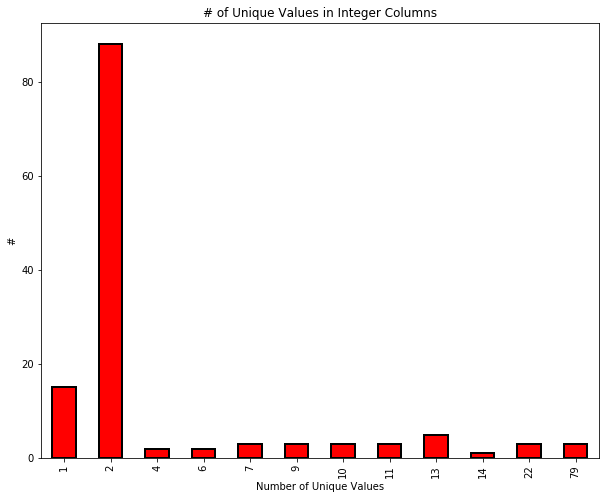

In [22]:
#looking at data types of variabels -- how many are binary or other?
#https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough

train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color = 'red', 
                                                                             figsize = (10,8),
                                                                            edgecolor = 'k', linewidth = 2);
plt.xlabel('Number of Unique Values'); plt.ylabel('#');
plt.title('# of Unique Values in Integer Columns');

Looks like the vast majority of our variables are binary, but some are continuous (more than two values possible as answers). Let's graph out these continuous variables and see how they are distributed across our target poverty classifications.

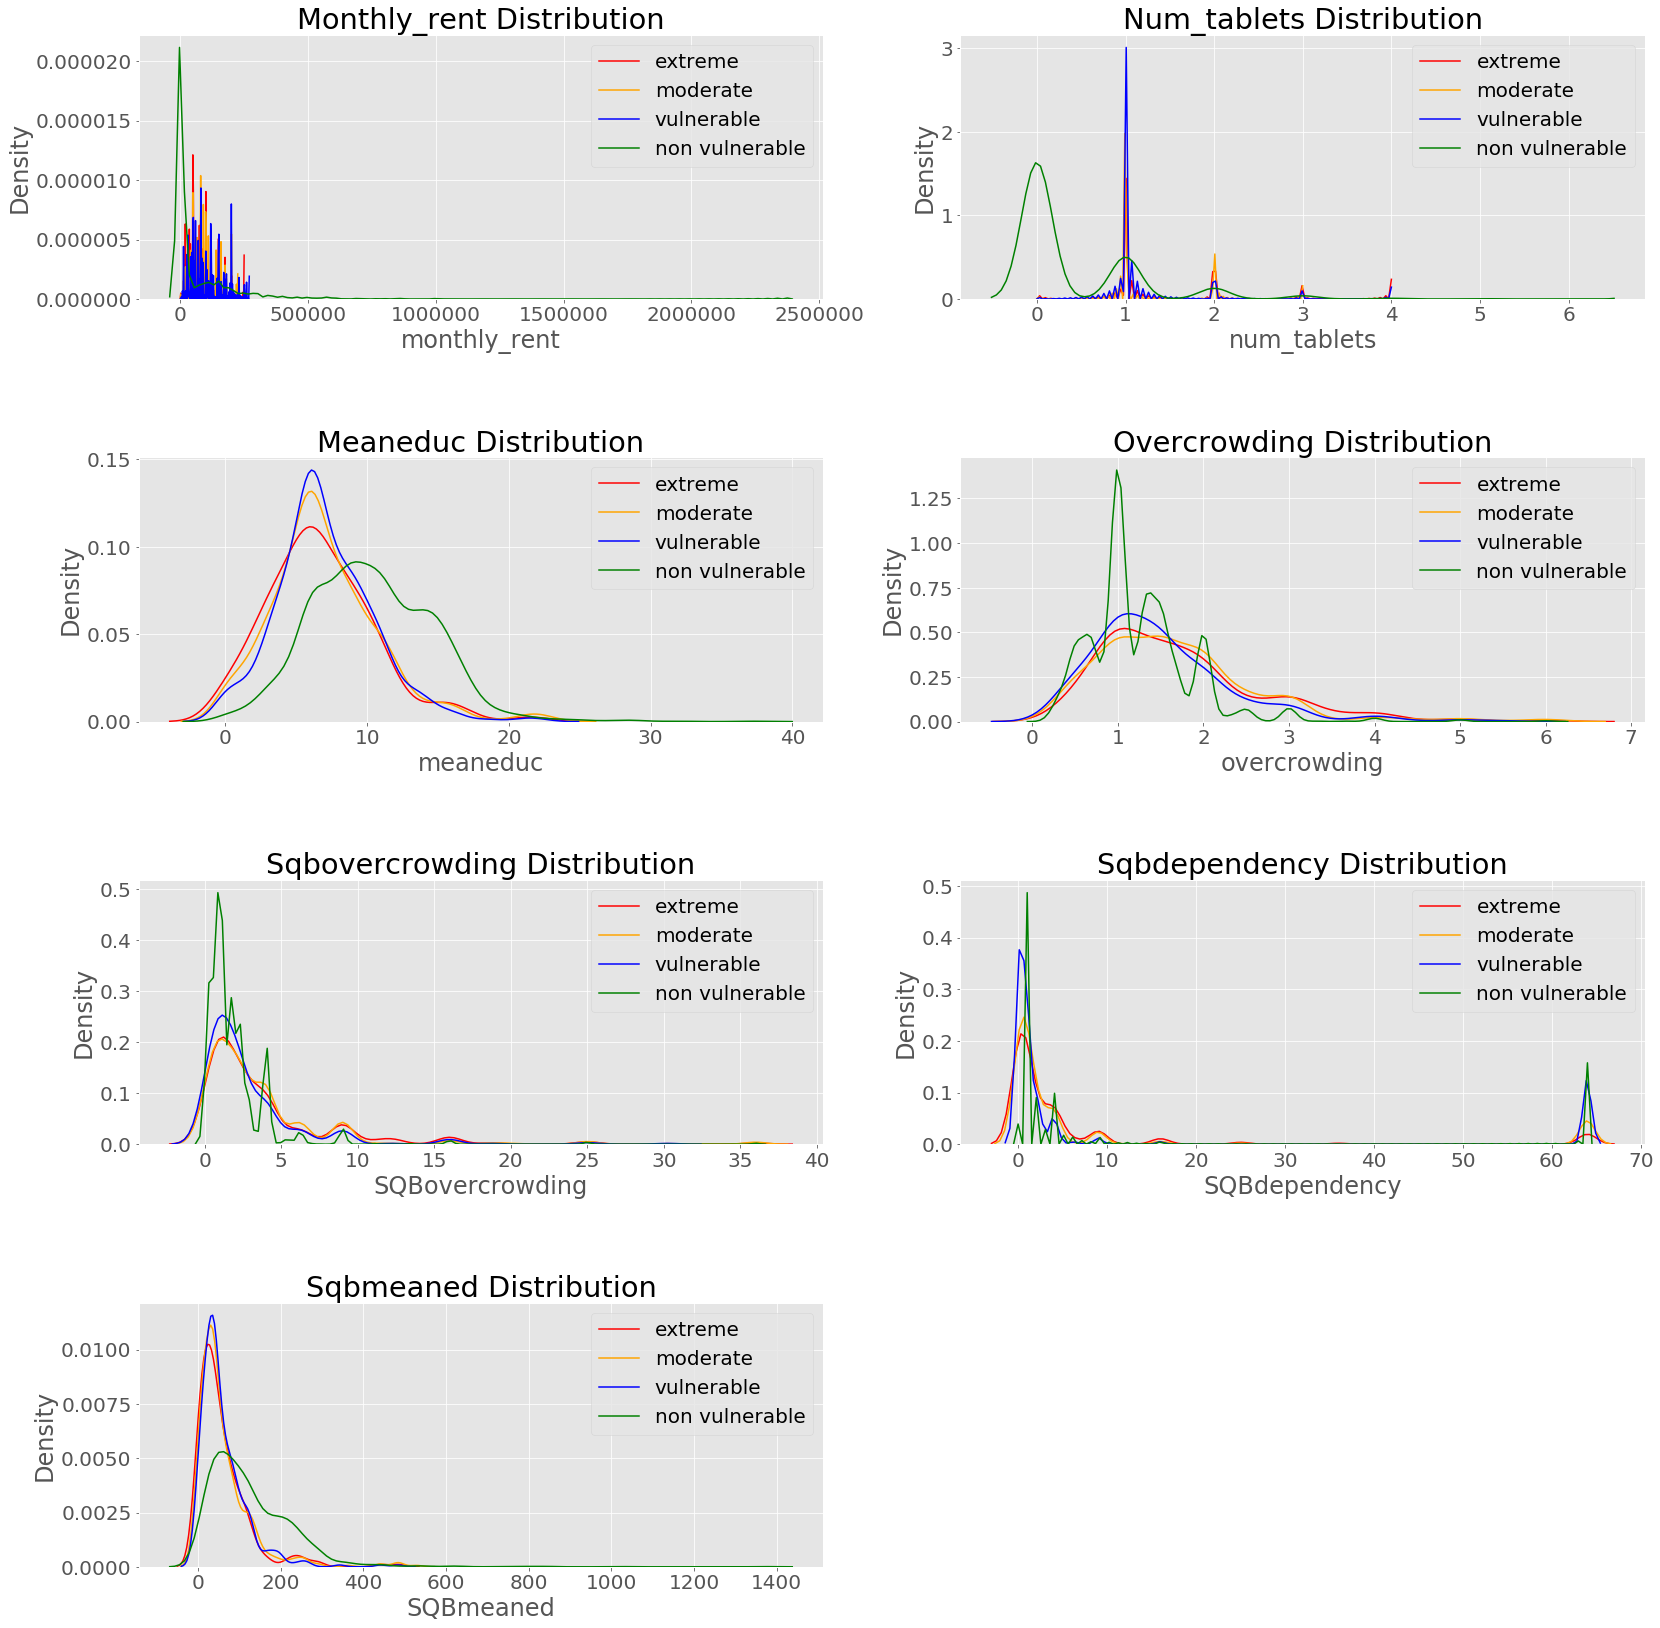

In [23]:
#visualizing our non-binary variables -- many of these appear to be generalized statistics of our data
plt.figure(figsize = (27, 27))
plt.style.use('ggplot')

train.rename(columns={'v2a1': 'monthly_rent', 'v18q1': 'num_tablets'}, inplace=True)

# Color mapping
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

plt.rcParams.update({'font.size': 20})

# Iterate through the float columns
for i, col in enumerate(train.select_dtypes('float')):
    ax = plt.subplot(9, 2, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.6)


In very broad terms, it appears that these indicators are incurred more extremely on the most and least vulnerable classes.

Education looks like it may indeed be very important to our estimations, so let's clean up a few of the education variables.  I'll change them to floats to be more applicably used in our models.

In [24]:
mapping = {"yes": 1, "no": 0}
train.rename(columns={'edjefa': 'femalehheduc', 'edjefe': 'malehheduc'}, inplace=True)

# Fill in the values with the correct mapping
train['dependency'] = train['dependency'].replace(mapping).astype(np.float64)
train['femalehheduc'] = train['femalehheduc'].replace(mapping).astype(np.float64)
train['malehheduc'] = train['malehheduc'].replace(mapping).astype(np.float64)

train[['dependency', 'femalehheduc', 'malehheduc']].describe()

,dependency,femalehheduc,malehheduc
count,2973.000000,2973.000000,2973.000000
mean,1.334008,3.177598,4.971746
std,2.145635,4.872542,5.318447
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.500000,0.000000,5.000000
75%,1.000000,6.000000,9.000000
max,8.000000,21.000000,21.000000


In [25]:
train.dependency.head()

0    0.0
1    8.0
2    8.0
5    1.0
8    1.0
Name: dependency, dtype: float64

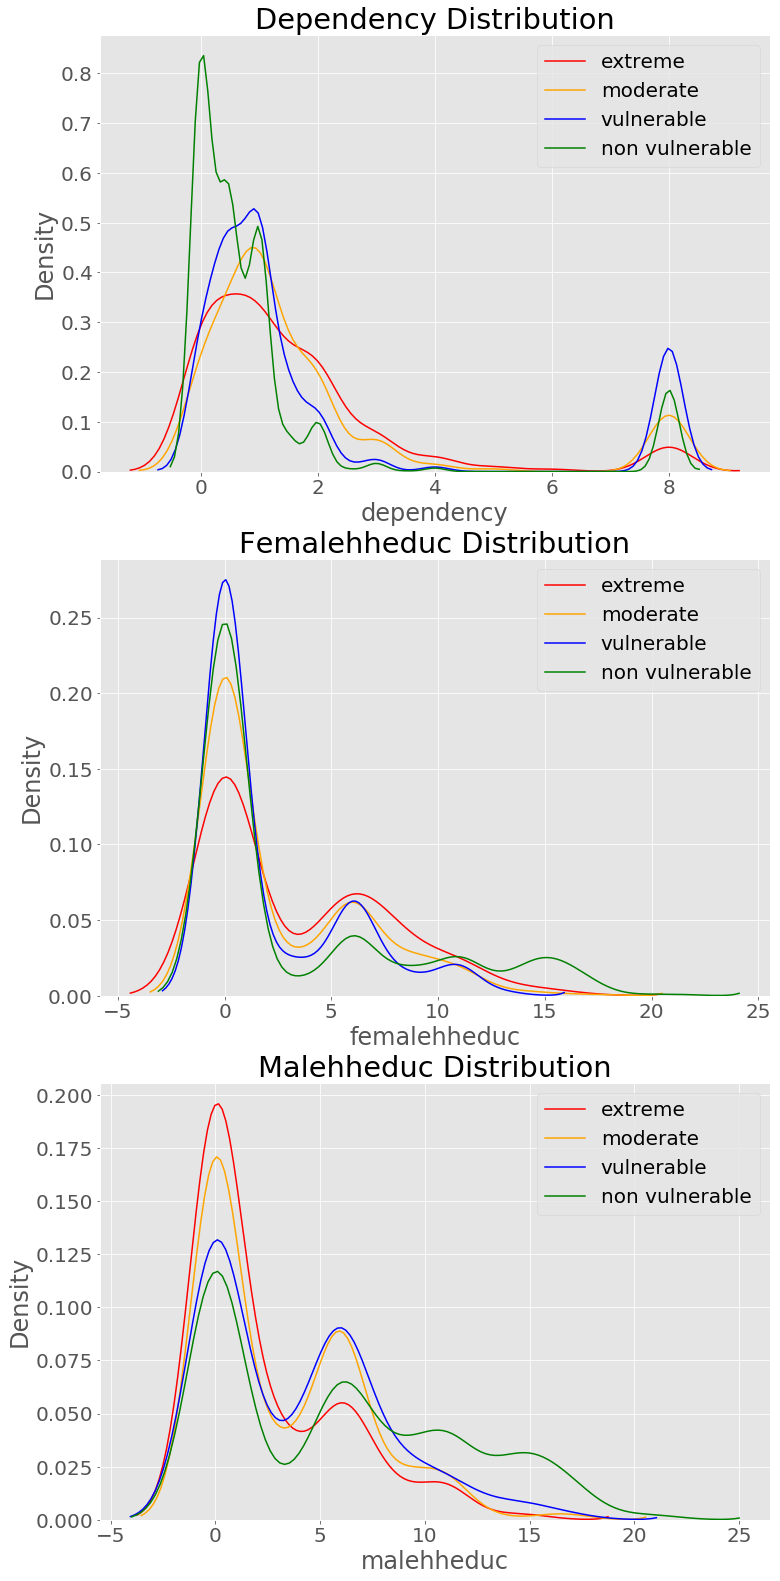

In [26]:
plt.figure(figsize = (12, 11))

for i, col in enumerate(['dependency', 'femalehheduc', 'malehheduc']):
    ax = plt.subplot(3, 1, i + 1)
    # trace a line for each poverty rank
    for poverty_level, color in colors.items():
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

Ironically, it appears that heads of household who are male and educated are the most at risk of being at risk of poverty.

Below are two more graphs that bring another perspective to the distribution of some of these variabels among poverty classes.

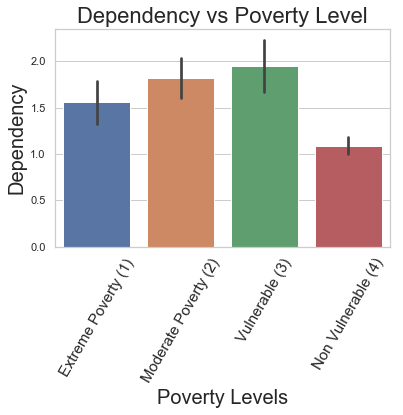

In [27]:
sns.set(style="whitegrid")
dependencyvstarget = sns.barplot(x="Target", y="dependency", data=train)
plt.xticks([0, 1, 2, 3],
           ['Extreme Poverty (1)', 'Moderate Poverty (2)', 'Vulnerable (3)', 'Non Vulnerable (4)'],
          rotation = 60, fontsize=15);
plt.xlabel('Poverty Levels', fontsize=20);
plt.ylabel('Dependency', fontsize=20);
plt.title('Dependency vs Poverty Level', fontsize=22);

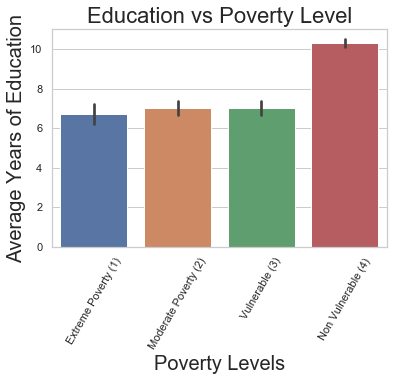

In [28]:
sns.set(style="whitegrid")
meaneducvstarget = sns.barplot(x="Target", y="meaneduc", data=train)
plt.xticks([0, 1, 2, 3],
           ['Extreme Poverty (1)', 'Moderate Poverty (2)', 'Vulnerable (3)', 'Non Vulnerable (4)'],
          rotation = 60);
plt.xlabel('Poverty Levels', fontsize=20);
plt.ylabel('Average Years of Education', fontsize=20);
plt.title('Education vs Poverty Level', fontsize=22);

# Modeling

Now that we've got to know our data a little better, let's see which of these variables has predictive power over 

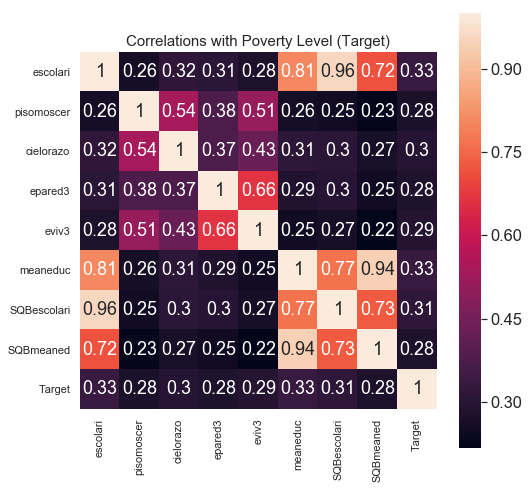

In [29]:
#creating a heatmap to display correlations between LotFrontage and other variables. 
#We are restricting this graph to variables that have at least a .3 correlation. 
correlations = train.corr()
TargetCorrelations = correlations.index[abs(correlations['Target'])>.275]
f, ax=plt.subplots(figsize=(8,8))
sns.set(font_scale=1.5)
plt.title('Correlations with Poverty Level (Target)', fontsize=15);
sns.heatmap(train[TargetCorrelations].corr(), square=True, annot=True);

In [30]:
# r4t1= persons younger than 12 years of age
# escolari = years of school
# pisomoscer = if predominant material on the floor is mosaic,  ceramic,  terrazo
# cielorazo = house has a ceiling
# hogarn_nin = number of children 0 to 19 in household
# meaneduc = average years of education for adults (18+)
# SQBhogar_nin= hogar_nin squared
# eviv3 = if floor are good
# overcrowding = # persons per room

In [31]:
#feature engineering
train['housequality'] = 0
train.loc[(train.epared3==1) & (train.eviv3==1), 'housequality'] = 1
train.drop(['escolari'], inplace=True, axis=1) #dropping because I'd rather use meaneduc// linearly correlated                                      

Now that I've modified and created a variable or two, I'll keep only the most correlated variables for my model. Below I will scale and change the data to dummies. This helps it be more intepretable by our models.

In [32]:
predictor = train.Target
train.drop(['Target'], axis=1, inplace=True) 
train = train[['r4t1','pisomoscer','cielorazo', 'meaneduc','eviv3','overcrowding', 'housequality']]

In [33]:
#turning data into dummies 
dummies_train = pd.get_dummies(train)

In [34]:
# Scale the training data
scaler = StandardScaler()
scaler.fit(dummies_train)
scaled_train = scaler.transform(dummies_train)

C:\Users\Malconius\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Malconius\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [35]:
#credit for this code goes to T.Folkman's lecture notebook on gridsearch and cross validation
y = predictor
x = scaled_train
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

def gridsearching(model):
   model.fit(X_train, y_train)
   print("Best Params: {}".format(model.best_params_))
   y_pred_train = model.predict(X_train)
   print("Train F1: {}".format(f1_score(y_train, y_pred_train, average="macro")))
   print("Test Classification Report:")
   y_pred_test = model.predict(X_test)
   print(classification_report(y_test, y_pred_test))
   print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                    accuracy_score(y_test, y_pred_test)))


Random_Forest = RandomForestClassifier(class_weight='balanced')

model = GridSearchCV(Random_Forest, {'max_depth': [3,4,5,6,7,8], 'n_estimators': [1,2,3,4,5,6,7,8,9,10,11,12]}, 
                     scoring="f1_macro")
gridsearching(model)


Best Params: {'max_depth': 7, 'n_estimators': 11}
Train F1: 0.5244333163931023
Test Classification Report:
              precision    recall  f1-score   support

           1       0.26      0.51      0.34        43
           2       0.28      0.34      0.31        91
           3       0.19      0.26      0.22        77
           4       0.86      0.65      0.74       384

   micro avg       0.54      0.54      0.54       595
   macro avg       0.40      0.44      0.40       595
weighted avg       0.64      0.54      0.58       595

Train Accuracy: 0.6211101766190076	Test accuracy: 0.5445378151260504


Sorry for the flood of warnings: if you didn't see the predictions for the RandomForest model, they are at the bottom of the warnings. 

In [36]:
knn = KNeighborsClassifier()
gridsearch = GridSearchCV(knn, {"n_neighbors": [1, 3, 5, 7, 9, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='f1_macro')
gridsearch.fit(X_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_train)
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_test)
print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))

Best Params: {'n_neighbors': 3, 'p': 3, 'weights': 'uniform'}
Test Classification Report:
              precision    recall  f1-score   support

           1       0.19      0.37      0.25        43
           2       0.23      0.20      0.21        91
           3       0.15      0.06      0.09        77
           4       0.77      0.80      0.78       384

   micro avg       0.58      0.58      0.58       595
   macro avg       0.33      0.36      0.34       595
weighted avg       0.56      0.58      0.57       595

Train Accuracy: 0.7338099243061396	Test accuracy: 0.5815126050420169


In [41]:
gbc = GradientBoostingClassifier()
gridsearch = GridSearchCV(gbc, {"learning_rate": [.1, .01, .001], "n_estimators": [100, 1000, 5000], 
                                'max_depth': [1, 2, 3]}, scoring='f1_macro')
gridsearch.fit(X_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_train)
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_test)
print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))

C:\Users\Malconius\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Malconius\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Malconius\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Malconius\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Malconius\Anaconda3\lib\site-packag

C:\Users\Malconius\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Malconius\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Malconius\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Malconius\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Malconius\Anaconda3\lib\site-packag

Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
Test Classification Report:
              precision    recall  f1-score   support

           1       0.19      0.12      0.14        43
           2       0.31      0.22      0.26        91
           3       0.20      0.12      0.15        77
           4       0.74      0.89      0.81       384

   micro avg       0.63      0.63      0.63       595
   macro avg       0.36      0.33      0.34       595
weighted avg       0.56      0.63      0.59       595

Train Accuracy: 0.81959629941127	Test accuracy: 0.6285714285714286



Surprisingly, the Random Forest model outperformed the Gradient Boost (0.37 vs 0.34 f1_macro on average, this changes for each run because it randomly selects its train and test set). 
In more meaningful terms, we can interpret the precision and recall of our models. 

Our Random Forest bested the other two models by a substantial margin in both precision and recall. This means that the Random Forest model successfully labeled poverty classes correctly labelled the classes 41% of the time and only incorrectly labels 38% of the time.

All in all, I think this is about as close as I can get under my time constraints.